In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

stocks = ['BBRI.JK', 'BMRI.JK', 'BBCA.JK']

data = yf.download(stocks, start='2021-01-01', end='2023-01-01')
print("Kolom yang tersedia dalam data:\n", data.columns)

data = data['Close']
print("Data saham (harian):\n", data.head())

daily_returns = data.pct_change().dropna()
print("\nReturn Harian:\n", daily_returns.head())

returns = (1 + daily_returns).resample('M').prod() - 1
print("\nReturn Bulanan (untuk GA):\n", returns.head())

def portfolio_return(weights, returns):
    return np.dot(returns.mean(), weights)

def portfolio_volatility(weights, returns):
    cov_matrix = returns.cov()
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def fitness_fn(weights, returns):
    vol = portfolio_volatility(weights, returns)
    if vol == 0:
        return -1e9
    return portfolio_return(weights, returns) / vol

def initialize_population(pop_size, n_assets):
    pop = np.random.rand(pop_size, n_assets)
    return pop / pop.sum(axis=1, keepdims=True)

def tournament_selection(pop, fitnesses, k=3):
    idx = np.random.choice(len(pop), size=k, replace=False)
    best = idx[np.argmax(fitnesses[idx])]
    return pop[best].copy()

def one_point_crossover(p1, p2):
    pt = np.random.choice([1, 2])
    c1 = np.concatenate([p1[:pt], p2[pt:]])
    c2 = np.concatenate([p2[:pt], p1[pt:]])
    return c1, c2

def mutate(weights, sigma=0.05, p_mut=0.3):
    for i in range(len(weights)):
        if np.random.rand() < p_mut:
            weights[i] += np.random.normal(0, sigma)
    weights = np.clip(weights, 0, None)
    s = weights.sum()
    if s == 0:
        return np.ones_like(weights) / len(weights)
    return weights / s

def run_ga(returns, pop_size=80, generations=50, elite_size=4):
    n_assets = returns.shape[1]
    pop = initialize_population(pop_size, n_assets)

    history = {"max_fit": [], "mean_fit": []}
    best_ind, best_fit = None, -1e9

    for gen in range(generations):
        fitnesses = np.array([fitness_fn(ind, returns) for ind in pop])

        history["max_fit"].append(fitnesses.max())
        history["mean_fit"].append(fitnesses.mean())

        elite_idx = fitnesses.argsort()[-elite_size:][::-1]
        new_pop = [pop[i].copy() for i in elite_idx]

        while len(new_pop) < pop_size:
            p1 = tournament_selection(pop, fitnesses)
            p2 = tournament_selection(pop, fitnesses)
            c1, c2 = one_point_crossover(p1, p2)
            c1 = mutate(c1)
            c2 = mutate(c2)
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)

        pop = np.array(new_pop)
        gen_best = pop[np.argmax(fitnesses)]

        if fitnesses.max() > best_fit:
            best_fit = fitnesses.max()
            best_ind = gen_best.copy()

    return best_ind, best_fit, history

best_weights, best_fit, history = run_ga(returns)

print("\nBobot terbaik (GA):", best_weights)
print("Fitness:", best_fit)

equal_weights = np.array([1/3, 1/3, 1/3])

mean_returns = returns.mean()
print("\nRata-rata return bulanan tiap saham:\n", mean_returns)

best_single_idx = np.argmax(mean_returns)

single_best_weights = np.zeros(3)
single_best_weights[best_single_idx] = 1

print(f"\nSaham return tertinggi index: {best_single_idx}")
print(f"Bobot Best Single Stock: {single_best_weights}")

def compute_metrics(w):
    return portfolio_return(w, returns), portfolio_volatility(w, returns)

ga_ret, ga_vol = compute_metrics(best_weights)
eq_ret, eq_vol = compute_metrics(equal_weights)
sb_ret, sb_vol = compute_metrics(single_best_weights)

results = pd.DataFrame({
    'Method': ['GA', 'Equal Weight', 'Best Single'],
    'BBRI': [best_weights[0], 1/3, single_best_weights[0]],
    'BMRI': [best_weights[1], 1/3, single_best_weights[1]],
    'BBCA': [best_weights[2], 1/3, single_best_weights[2]],
    'Avg Monthly Return': [ga_ret, eq_ret, sb_ret],
    'Volatility': [ga_vol, eq_vol, sb_vol],
    'Fitness': [ga_ret/ga_vol, eq_ret/eq_vol, sb_ret/sb_vol]
})

print("\nHasil Perbandingan:\n", results)

C:\Users\muham\AppData\Local\Temp\ipykernel_25396\3338808911.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stocks, start='2021-01-01', end='2023-01-01')
[*********************100%***********************]  3 of 3 completed
C:\Users\muham\AppData\Local\Temp\ipykernel_25396\3338808911.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = (1 + daily_returns).resample('M').prod() - 1


Kolom yang tersedia dalam data:
 MultiIndex([( 'Close', 'BBCA.JK'),
            ( 'Close', 'BBRI.JK'),
            ( 'Close', 'BMRI.JK'),
            (  'High', 'BBCA.JK'),
            (  'High', 'BBRI.JK'),
            (  'High', 'BMRI.JK'),
            (   'Low', 'BBCA.JK'),
            (   'Low', 'BBRI.JK'),
            (   'Low', 'BMRI.JK'),
            (  'Open', 'BBCA.JK'),
            (  'Open', 'BBRI.JK'),
            (  'Open', 'BMRI.JK'),
            ('Volume', 'BBCA.JK'),
            ('Volume', 'BBRI.JK'),
            ('Volume', 'BMRI.JK')],
           names=['Price', 'Ticker'])
Data saham (harian):
 Ticker          BBCA.JK      BBRI.JK      BMRI.JK
Date                                             
2021-01-04  6028.375000  3006.586670  2467.006836
2021-01-05  6253.280762  2978.683350  2438.541260
2021-01-06  6125.393066  2929.852295  2438.541260
2021-01-07  6143.032227  2985.658936  2457.518311
2021-01-08  6218.001953  3062.393311  2485.983887

Return Harian:
 Ticker       B

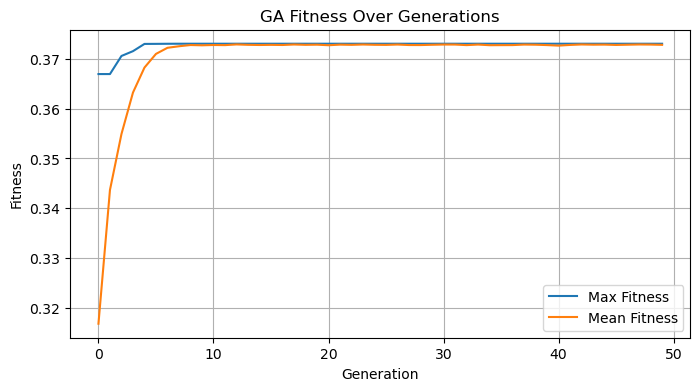

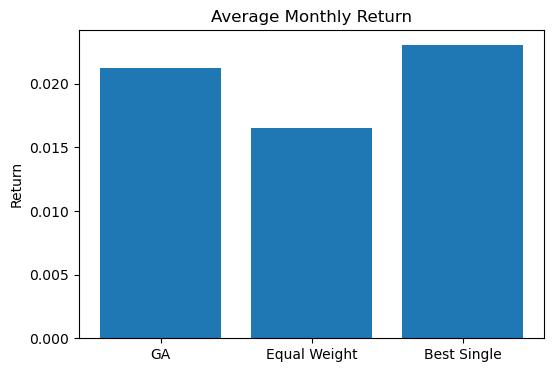

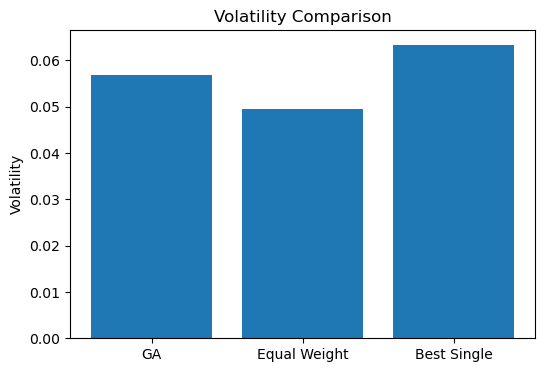

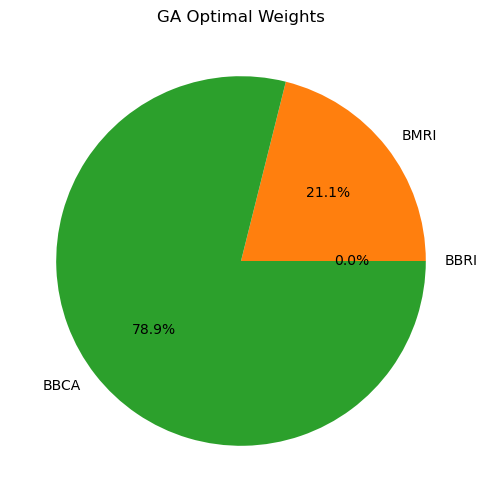

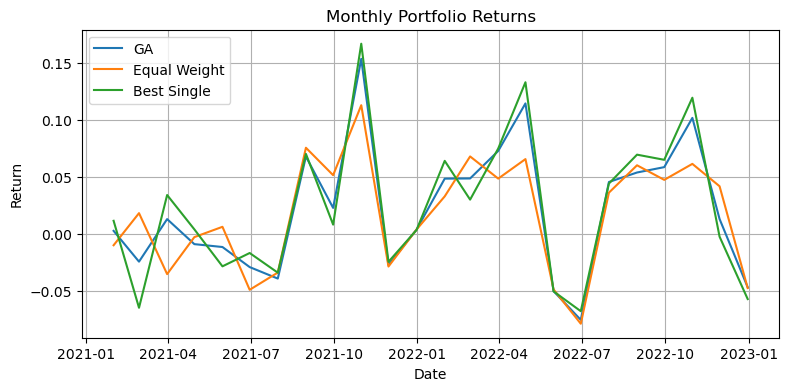

In [3]:
plt.figure(figsize=(8,4))
plt.plot(history['max_fit'], label='Max Fitness')
plt.plot(history['mean_fit'], label='Mean Fitness')
plt.title("GA Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(results['Method'], results['Avg Monthly Return'])
plt.title("Average Monthly Return")
plt.ylabel("Return")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(results['Method'], results['Volatility'])
plt.title("Volatility Comparison")
plt.ylabel("Volatility")
plt.show()

plt.figure(figsize=(6,6))
plt.pie(best_weights, labels=['BBRI','BMRI','BBCA'], autopct='%1.1f%%')
plt.title("GA Optimal Weights")
plt.show()

ga_series = returns.dot(best_weights)
eq_series = returns.dot(equal_weights)
sb_series = returns.dot(single_best_weights)

plt.figure(figsize=(9,4))
plt.plot(returns.index, ga_series, label='GA')
plt.plot(returns.index, eq_series, label='Equal Weight')
plt.plot(returns.index, sb_series, label='Best Single')
plt.title("Monthly Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()